In [3]:
import pmdarima as pm
import numpy as np # Para trabajar con vectores y matrices
from matplotlib import pyplot as plt # Para graficar
import pandas as pd # Para trabajar con bases de datos
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression import linear_model
import statsmodels.api as sm
from patsy import dmatrices
plt.style.use('fivethirtyeight') # Para dar un estilo distinto a los gráficos
#import seaborn as sns

## ¿Es posible complementar el análisis anterior con alguna variable exógena?

Durante el análisis de la serie surgieron preguntas tales cómo:

* ¿Puede añadirse información de otras medidas ambientales para obtener un análisis más preciso?
* ¿Existe algún otro factor que influya con el clima promedio en Colombia?

Entre otros.

### Deforestación en Colombia:

*Párrafo de contexto sobre deforestación en Colombia*

En este caso se incluye información acerca de la deforestación en Colombia ya que se tiene interés en saber sí a la hora de talar arboles contribuimos a que el clima sea más calido en Colombia.

### Datos

En este caso obtenemos datos de rainforest 


Que contienen información acerca de

In [ ]:
# Lectura base de datos
clima = pd.read_csv('data/medidas_clima.csv', parse_dates=['date'])
# Agrupación por año
clima['Año'] = clima['date'].dt.year
# Filtrado de años
clima = clima[clima['Año'] > 2001]
# Agrupacion de , promedio por año
resumen_anual = clima.groupby('Año').mean()
resumen_anual.reset_index(drop=False, inplace=True)
# Encabezado datos
resumen_anual.head()

In [5]:
# Carga de datos de perdida de cobertura arborea
perdida_cobertura = pd.read_csv('assets/treecover_loss__ha.csv')
# Limpieza de datos
perdida_cobertura.drop(columns='iso', inplace=True)
# Seleccion de columnas de interés
perdida_cobertura = perdida_cobertura.iloc[:, range(2)]
# Renombramiento de columnas
perdida_cobertura.columns = ['Año', 'value']

In [6]:
# Datos de cobertura
intervencion = pd.read_csv('assets/arboles.txt', sep=": ", thousands=",")
intervencion.head()

C:\Users\juant\AppData\Local\Temp\ipykernel_8392\4051545259.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  intervencion = pd.read_csv('assets/arboles.txt', sep=": ", thousands=",")


,Año,Cantidad
0,2002,63302
1,2003,32050
2,2004,81695
3,2005,58906
4,2006,56051


In [7]:
# Estandarización de datos:
perdida_cobertura['value'] = (perdida_cobertura['value'] - perdida_cobertura['value'].mean())/perdida_cobertura['value'].std()
resumen_anual['value'] = (resumen_anual['value'] - resumen_anual['value'].mean())/ resumen_anual['value'].std()
intervencion['Cantidad'] = (intervencion['Cantidad'] - intervencion['Cantidad'].mean())/ intervencion['Cantidad'].std()

In [8]:
# Base de datos para futuro modelo
base_modelo = resumen_anual.copy()
base_modelo = base_modelo[(base_modelo['Año'] >2001) & (base_modelo['Año'] < 2021)]
base_modelo['aux'] = perdida_cobertura['value']
base_modelo['aux2'] = intervencion['Cantidad']

Se construye una matriz de correlación con el fin de encontrar posibles relaciones entre la variable auxiliar, el tiempo y la temperatura en Colombia para determinado año:

In [9]:
# matriz de correlación
base_modelo.corr()

,Año,value,aux,aux2
Año,1.000000,0.597323,0.458065,0.705135
value,0.597323,1.000000,-0.046368,0.148540
aux,0.458065,-0.046368,1.000000,0.603576
aux2,0.705135,0.148540,0.603576,1.000000


<AxesSubplot: >

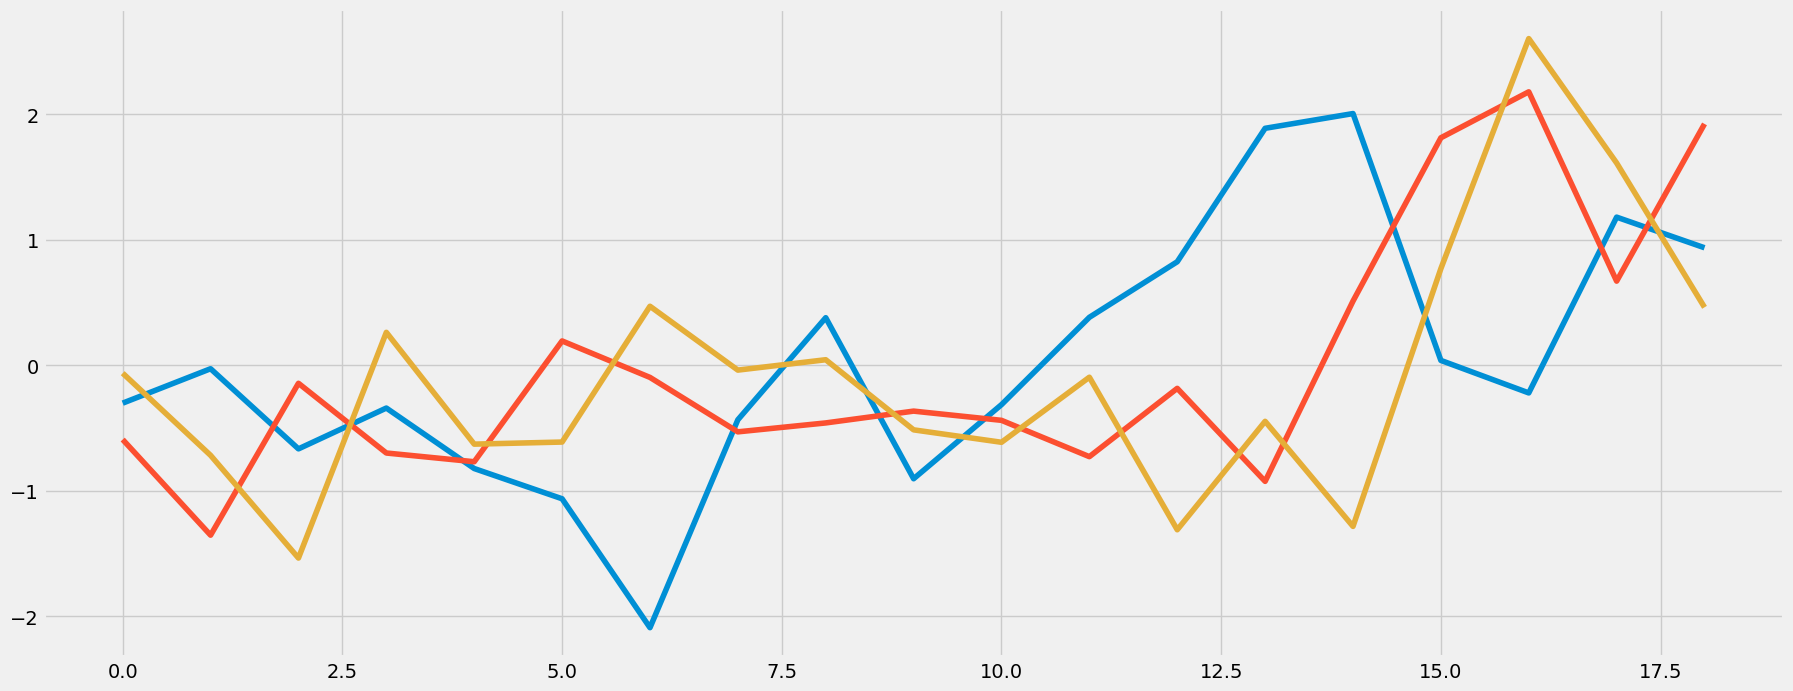

In [21]:
base_modelo['value'].plot(figsize = (20,8))
base_modelo['aux2'].plot()
base_modelo['aux'].plot()

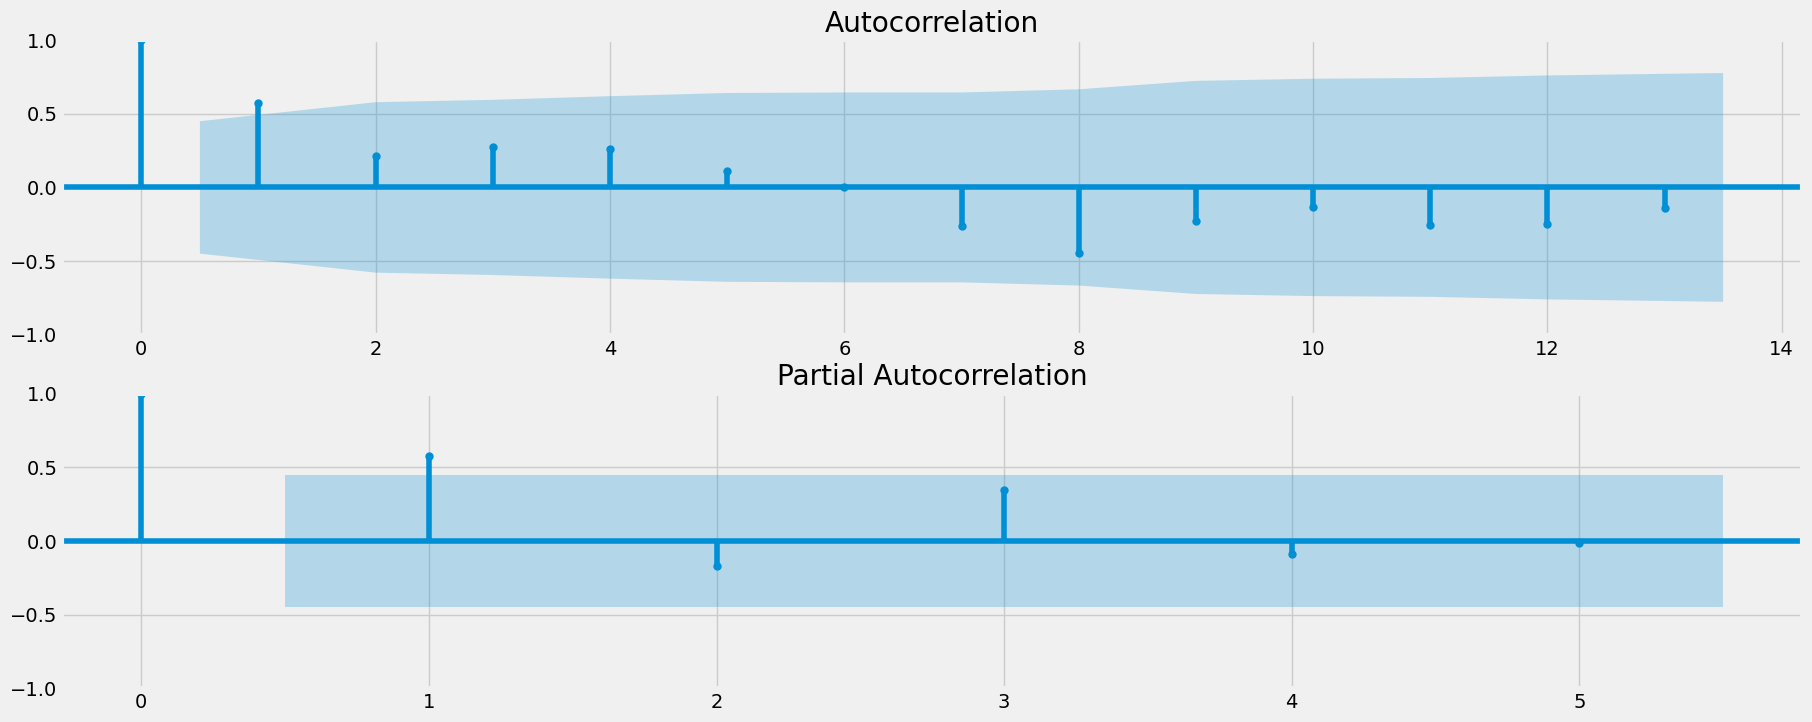

In [26]:
figure, axis = plt.subplots(2,1)
figure.set_size_inches(20,8)

plot_acf(base_modelo['value'], ax=axis[0]);
plot_pacf(base_modelo['value'], ax=axis[1], method = 'ywm', lags=5);

In [12]:
adfuller(base_modelo['value'])
base_modelo

,Año,value,aux,aux2
0,2002,-0.301884,-0.063364,-0.592058
1,2003,-0.027855,-0.717683,-1.353614
2,2004,-0.666254,-1.535991,-0.143853
3,2005,-0.341032,0.262049,-0.699181
4,2006,-0.822842,-0.628556,-0.768752
5,2007,-1.063748,-0.611865,0.193500
6,2008,-2.090607,0.469859,-0.096969
7,2009,-0.434382,-0.038810,-0.530601
8,2010,0.378673,0.043844,-0.459568
9,2011,-0.904148,-0.514676,-0.365458


Según el test de dickey fuller indica que la serie es estacionaria.

In [13]:
# Division datos entrenamiento y validación:
prueba = base_modelo[base_modelo['Año'] < 2019]
validacion = base_modelo[base_modelo['Año'] >= 2019]

In [14]:
# Modelo auto_arima con variables exogenas
arboles_arima = pm.auto_arima(y=prueba['value'].values, X=prueba['aux2'].values.reshape(-1,1), d=0)

In [15]:
arboles_arima

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
arboles_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -19.115
Date:                Wed, 16 Nov 2022   AIC                             44.231
Time:                        09:10:55   BIC                             46.730
Sample:                             0   HQIC                            44.479
                                 - 17                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4503      0.355     -1.269      0.204      -1.146       0.245
ar.L1          0.7093      0.218      3.261      0.001       0.283       1.136
sigma2         0.5325      0.258      2.061      0.039       0.026       1.039
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.97   Prob(JB):                         0.74
Heteroskedasticity (H):               4.27   Skew:                            -0.23
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

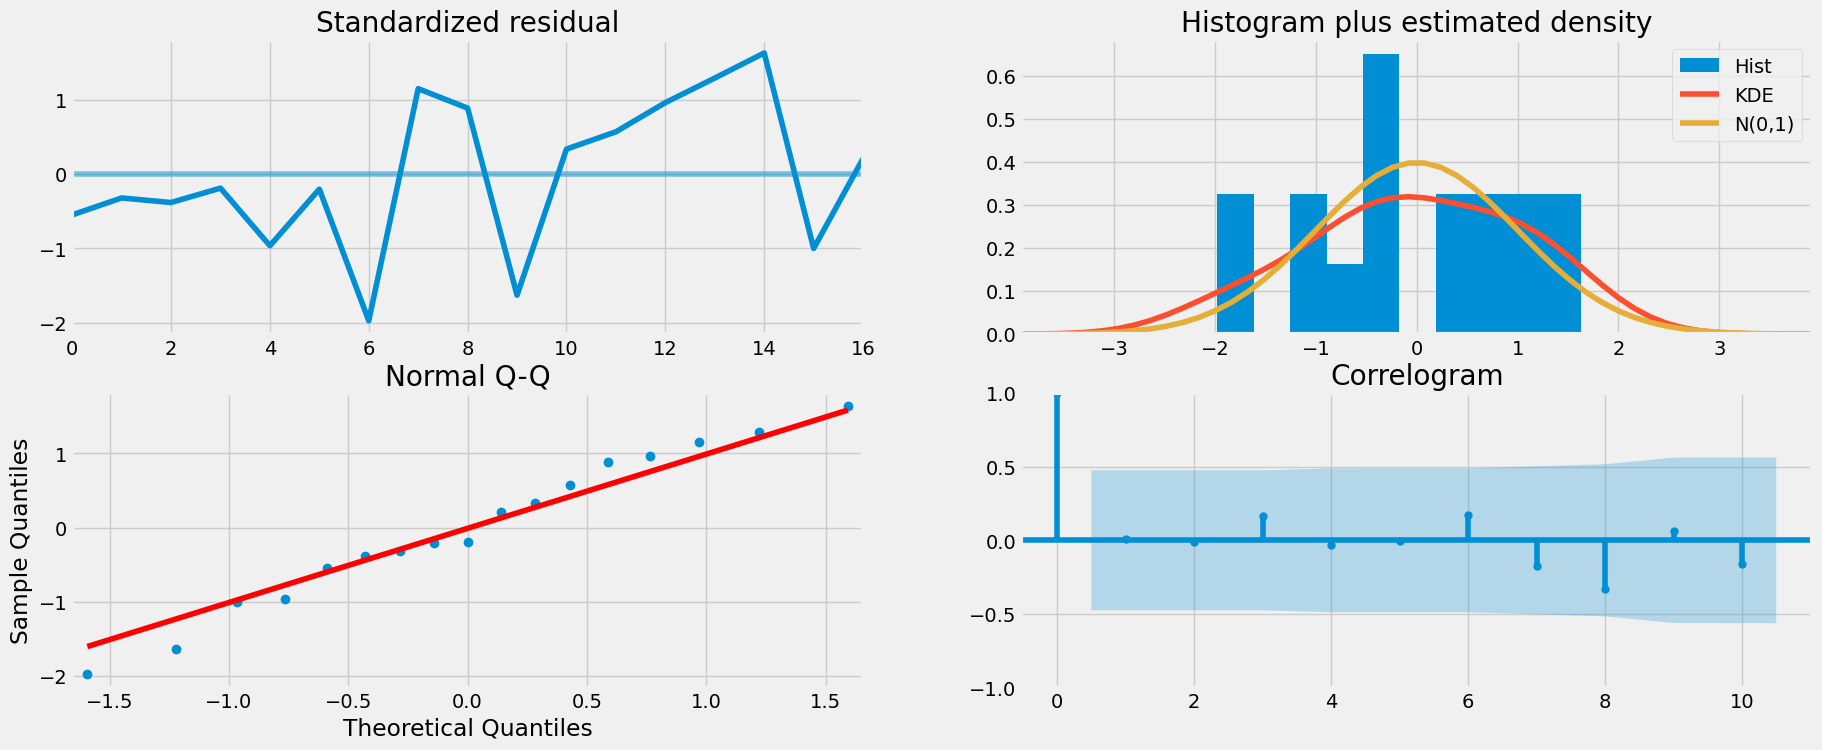

In [27]:
arboles_arima.plot_diagnostics(figsize=(20, 8));

In [18]:
sm.stats.acorr_ljungbox(arboles_arima.resid(), lags=15, return_df=True)

,lb_stat,lb_pvalue
1,0.003542,0.952543
2,0.004411,0.997797
3,0.628439,0.889892
4,0.634829,0.959116
5,0.635416,0.986324
6,1.776750,0.939044
7,2.935598,0.890895
8,6.933037,0.543874
9,7.190365,0.617307
10,8.455188,0.584466


In [ ]:
## Predicciones de validación cruzada
predicciones_arboles = arboles_arima.predict(n_periods=2, X=validacion['aux2'].values.reshape(-1,1))

validacion['predicciones'] = predicciones_arboles

<AxesSubplot: >

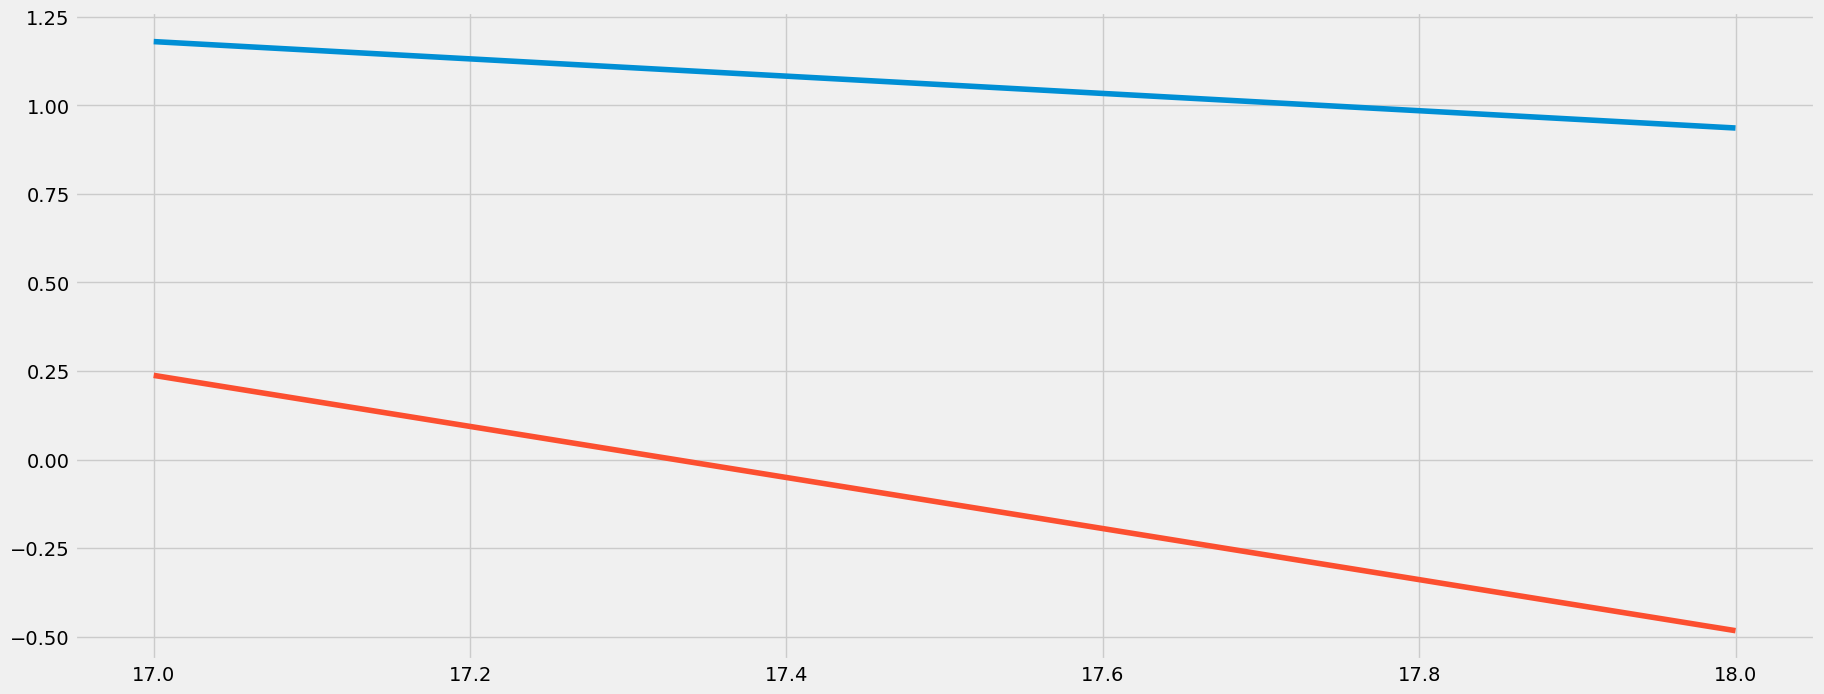

In [28]:
validacion['value'].plot(figsize=(20, 8))
validacion['predicciones'].plot()

## Recomendaciones y conclusiones:

* Realizar una búsqueda más exhaustiva de covariables con las que plantear algún modelo que prediga el clima promedio anual de Colombia.
* Plantear utilizar modelos locales o no paramétricos como LOESS o smoothing splines que se adecuen más a los datos utilizados para plantear el modelo.
* Mediante este ejercicio se entiende que NO todas las series son tan gratificantes de modelar